# Plotting Rainfall Rates using NEXRAD Data and PyART

This code uses Amazon S3 to access the radar files and download them.
Gridded radar data is then converted to rainfall rate and turned into an animated GIF. This code specifcally alters the default time stamp and title and converts it to 12-hour local time.

In [2]:
import warnings
warnings.filterwarnings('ignore')

from pylab import *
import pyart, boto3, tempfile, os, shutil, datetime, matplotlib
import numpy as np
import pandas as pd
import pylab as pl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import animation
from botocore.handlers import disable_signing
from glob import glob
import xarray as xr
import netCDF4
import cartopy
from datetime import datetime
import cartopy.io.shapereader as shpreader
from matplotlib.animation import FuncAnimation
import glob
from dateutil import tz

We are examining the case of April 18, 2013. This was an extraordinary 2-day event (from the 17th to the 18th) that produced the highest rainfall totals the Chicago metropolitan area and surrounding suburbs have ever experienced in such a short time frame. Over 7 inches of rainfall was reported in some areas. Widespread flooding occured as drainage systems were quickly overwhelmed by the high amounts of rain that fell onto already saturated soil. Nearly every river in the area swelled to record levels, well exceeding the "flood stage". Many of these records have not been broken since.

On this day, the SPC had placed the Chicagoland area under a SLGHT outlook which was downgraded to a TSTM outlook as the day progressed (this is also 2013 SPC outlooks, which only had 4 total probability categories, HIGH, MODERATE, SLIGHT, and THUNDERSTORM, versus the six categories present today). Flooding liklihood is not a severe weather hazard included in the outlook calculations.

Upon first glance at the synoptic setup, a slow-moving storm system was the main feature present. A stalled cold front near the Mississippi River (the frontal boundary would become parallel to the southeasterly upper-level flow, increasing longevity of the system and contributing to the front's stalled motion) and moisture advection courtesy of an upper-level ridging feature are contributing factors to the scale and intensity of the event. Warm, saturated air was advected into the region and then lifted by the slow-moving front, creating a barrage of rain and storms that would continue until the front's eventual departure from the area in the late afternoon hours on April 18.

Inadequate draining systems and a lack of preparedness can increase the devastation brought on by severe flooding events. While flooding might not be the most interesting or intense weather hazard, it can certainly be among the most destructive. We intend to study some of these rainfall events to better understand their processes and aid hydrologists and engineers working on  drainage systems in the Chicagoland area.

Using AmazonS3, we were able to pull all of the day's NEXRAD radar scans from the KLOT site in Romeoville, IL. With this method, the radar files do not need to be individually downloaded, saving time and computer memory.

In [3]:
# Obtaining radar scans...
def get_radar_scan(station='KLOT', date=None, key_index=-20):
    
    '''
    Function will pull the latest radar scan from any radar site using 
    Amazon S3.
    ----------
    Station = Four letter NEXRAD identifier
              Example: 'KEPZ'
    Date = default is none for current date, else enter date in format "YYYY/MM/DD"
    Ex: date ='2013/11/17
    Key_index = Number of keys you want pulled from most recent scan.
    Ex: key_index = -15 would pull ht most recent 15 scans
    '''
    
    # Creating a bucket and a client to be able to pull data from AWS and setting it as unsigned
    bucket = 'noaa-nexrad-level2'
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    # Connects the bucket create above with radar data
    aws_radar = s3.Bucket(bucket)
    
    # Setting the date and time to current...
    # This will allow for allow the current date's radar scands to be pulled
    if date == None:
        target_string = datetime.datetime.utcnow().strftime('%Y/%m/%d/'+station)
    else:
        target_string = date+'/'+station
    
    for obj in aws_radar.objects.filter(Prefix= target_string):
        '{0}:{1}'.format(aws_radar.name, obj.key)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix= target_string)]
    keys = my_list_of_keys[key_index:]
    for key in keys:
        if 'MDM' in key:
            keys.remove(key)
    print(keys)
    return aws_radar, keys

Below, we are choosing the specific timeframe from which we will obtain our data scans. A high key index was chosen as to be sure that every scan from the day was obtained. This older NEXRAD data included .tar files towards the end of the period, which this particular code cannot process. Once those files begin, that signals the end of the period we will be examining for this particular event.

In [4]:
# Setting radar, date of radar scans needed, and key index (amount of items in list)
aws_radar, keys = get_radar_scan(station='KLOT', date='2019/05/27', key_index=-400) 
out_path_dir = 'home/amedendorp/Desktop/april182013'

['2019/05/27/KLOT/KLOT20190527_000114_V06', '2019/05/27/KLOT/KLOT20190527_000759_V06', '2019/05/27/KLOT/KLOT20190527_001453_V06', '2019/05/27/KLOT/KLOT20190527_002158_V06', '2019/05/27/KLOT/KLOT20190527_002851_V06', '2019/05/27/KLOT/KLOT20190527_003550_V06', '2019/05/27/KLOT/KLOT20190527_004240_V06', '2019/05/27/KLOT/KLOT20190527_004945_V06', '2019/05/27/KLOT/KLOT20190527_005649_V06', '2019/05/27/KLOT/KLOT20190527_010348_V06', '2019/05/27/KLOT/KLOT20190527_011054_V06', '2019/05/27/KLOT/KLOT20190527_011753_V06', '2019/05/27/KLOT/KLOT20190527_012451_V06', '2019/05/27/KLOT/KLOT20190527_013157_V06', '2019/05/27/KLOT/KLOT20190527_013856_V06', '2019/05/27/KLOT/KLOT20190527_014602_V06', '2019/05/27/KLOT/KLOT20190527_015301_V06', '2019/05/27/KLOT/KLOT20190527_020006_V06', '2019/05/27/KLOT/KLOT20190527_020701_V06', '2019/05/27/KLOT/KLOT20190527_021405_V06', '2019/05/27/KLOT/KLOT20190527_022111_V06', '2019/05/27/KLOT/KLOT20190527_022816_V06', '2019/05/27/KLOT/KLOT20190527_023521_V06', '2019/05/2

In [6]:
# Obtaining every 7th step (approximately every half hour). 
# Remove bracket to include every scan.
nk = keys[185:186]
nk

['2019/05/27/KLOT/KLOT20190527_183744_V06']

In [7]:
localfile = tempfile.NamedTemporaryFile()
aws_radar.download_file(keys[0], localfile.name)
radar = pyart.io.read(localfile.name)
radar.fields.keys()

dict_keys(['velocity', 'differential_phase', 'reflectivity', 'differential_reflectivity', 'cross_correlation_ratio', 'spectrum_width'])

The next step is gridding the data. This block of code will plot the radar data onto a Cartesian grid and then save it into a predetermined file for easy access later. By splicing the list (as above), we can obtain data at different intervals, say every 7 scans, which is about every half hour. Or, we can simply grid every radar file.

The code below (courtesy of pyART) also creates a rainfall rate field from the basic reflectivity data contained within the radar scans. It estimates rainfall rate from reflectivity using a power law. Alpha and beta are optional float variables, with alpha being the factor and beta being the exponent of the power law.

In [8]:
# Turning the data into grid data and saving it to a folder...
# If the grids are already created, there is no need to run this code block again.
def get_grid(aws_radar, nk):
    localfile = tempfile.NamedTemporaryFile()
    aws_radar.download_file(nk, localfile.name)
    radar = pyart.io.read(localfile.name)
    # Create rainfall rate field
    rr = pyart.retrieve.est_rain_rate_z(radar, alpha=0.0376, beta=0.6112, refl_field=None, rr_field=None)
    radar.add_field('rain_rate', rr, replace_existing=True)
    # Mask out last 10 gates of each ray, this removes the "ring" around the radar.
    radar.fields['rain_rate']['data'][:, -10:] = np.ma.masked

    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.exclude_below('rain_rate', 1)
    gatefilter.exclude_transition()
    gatefilter.exclude_masked('rain_rate')
    grid = pyart.map.grid_from_radars(
            (radar, ), grid_shape=(1, 300, 300),
            grid_limits=((2000, 2000), (-123000.0, 123000.0), (-123000.0, 123000.0)),
            fields=['rain_rate'], weighting_function='Barnes2',
            gridding_algo='map_gates_to_grid',
            h_factor=0., nb=0.6, bsp=1., min_radius=500., gatefilters=(gatefilter, ))
    del radar
    return grid

for num,key in enumerate(nk):
    print('saving grid', num)
    grid = get_grid(aws_radar, key)
    name = os.path.join('/home/amedendorp/Desktop/Rain_Rate' 
                        + str(num).zfill(3) + '.nc')
    pyart.io.write_grid(name, grid)
    del grid
# If the code encounters a .tar file or any other unknown file, it will stop running.
# Every grid created before that will be preserved.

saving grid 0


In order to add counties to the grids and plots, a separate county file was downloaded from nationalmap.gov (https://nationalmap.gov/small_scale/atlasftp.html?openChapters=chpbound#chpbound). This will allow us to add county shapes, as there is no default county feature in cartopy.

In [9]:
reader = shpreader.Reader('/home/amedendorp/Downloads/countyl010g_shp_nt00964/countyl010g.shp')
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

### Creating an animation of the grids using PyART:

Using glob to sort the grids based on their timestamps:

In [10]:
files = glob.glob('/home/amedendorp/Desktop/Rain_Rate*')
files.sort()

Now that we have the grid plots of rainfall rate created and saved, we can animate them. This next code block loops through the grids and creates an animation. It's also simultaneously converting the default UTC time that pyART includes in the title to local time using netCDF4 num2date in addition to plotting the location of various sites. The animation will then be saved to the specified folder.

2019-05-27 18:37:44.662000
2019-05-27 18:37:44.662000


<function matplotlib.pyplot.close(fig=None)>

2019-05-27 18:37:44.662000


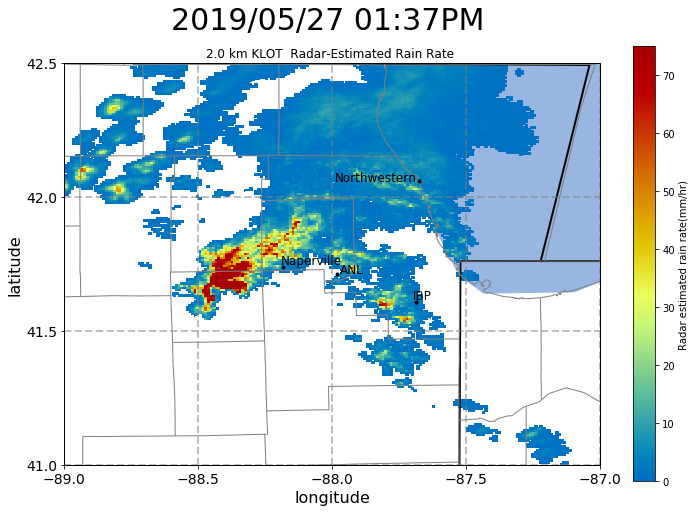

In [11]:
# This code was created using a modified version of pyART. The only thing that will change versus default
# pyART is the thickness and color of the lat and lon lines, and the county and state outlines.
def rr_animation(nframe): 
    plt.clf()
    nfile = files[nframe]
    radar = pyart.io.read_grid(nfile)

    # Converting the default UTC time to local time...
    # Converts to 24-hour time. No AM or PM.
    utc = netCDF4.num2date(radar.time['data'][0],
                       radar.time['units'])
    print(str(utc))
    z = datetime.strptime(str(utc), '%Y-%m-%d %H:%M:%S.%f')
  
    from_zone = tz.tzutc()
    to_zone = tz.tzlocal()
    z = z.replace(tzinfo=from_zone)
    central = z.astimezone(to_zone)
    t = datetime.strftime(central, '%Y/%m/%d')
    m = datetime.strftime(central, ' %I:%M%p')

#     title = ('KLOT ' + ' Radar-Derived Rain Rate ')

# Longer title with extra information:
    title = ( str(radar.z['data'][0]/1000) + ' km ' + 'KLOT ' + ' Radar-Estimated Rain Rate ')



    projection = ccrs.PlateCarree()
    
    ax = plt.axes(projection=projection)
    
    # Plot site locations...
    ANL_lon, ANL_lat = -87.981810, 41.713969 
    NW_lon, NW_lat = -87.675885, 42.057888
    Naperville_lon, Naperville_lat = -88.181798, 41.738107
    IBP_lon, IBP_lat = -87.687151, 41.606367

    plt.plot([ANL_lon], [ANL_lat], color='black', marker= '.')
    plt.plot([NW_lon], [NW_lat], color='black', marker= '.')
    plt.plot([Naperville_lon], [Naperville_lat], color='black', marker= '.')
    plt.plot([IBP_lon], [IBP_lat], color='black', marker= '.')

    # Plot names of sites:
    plt.text(ANL_lon + 0.01, ANL_lat - 0., 'ANL', horizontalalignment='left', fontsize=12)
    plt.text(NW_lon - 0.01, NW_lat - 0, 'Northwestern', horizontalalignment='right', fontsize=12)
    plt.text(Naperville_lon - 0.01, Naperville_lat + 0.01, 'Naperville', horizontalalignment='left', fontsize=12)
    plt.text(IBP_lon - 0.01, IBP_lat + 0.01, 'IBP', horizontalalignment='left', fontsize=12)
    
    #Plot the date and time above and slightly larger than the title:
    plt.text(-88.6, 42.5, t + m + ' \n', horizontalalignment='left', fontsize = 30)
    
    display = pyart.graph.GridMapDisplay(radar)
    display.plot_grid('rain_rate', cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                      vmin=0, vmax=75, lat_lines=np.arange(41, 43, .5),
                      lon_lines=np.arange(-89, -86.5, .5), projection=projection,
                      embelish=True, title=title)
    plt.rcParams.update({'axes.titlesize': '20'})
    ax.tick_params(labelsize=14) 
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['font.size']=16
    plt.rcParams['ytick.labelsize']=14
    plt.ylabel("latitude", fontsize = 16)
    plt.xlabel("longitude", fontsize = 16)
    
    del radar, display
    ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')
    ax.add_feature(cfeature.LAKES, zorder=.5)
    
    
fig = plt.figure(figsize=[12,8])

# Match the frames to the amount of grids
sat_anim = FuncAnimation(fig, rr_animation, frames=1)
sat_anim.save('/home/amedendorp/Desktop/May_27_Poster.png',
              writer='imagemagick', fps=3)
plt.close

NameError: name 'radar' is not defined